In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.utils import shuffle

from sklearn.preprocessing import Imputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 100)
sns.set(style='white', context='notebook')

# lightgbm 설치 해야함.

In [2]:
trainset = pd.read_csv('./input/train (2).csv')
testset = pd.read_csv('./input/test (2).csv')

In [3]:
trainset.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


In [5]:
print('Train dataset (rows, cols):', trainset.shape, '\nTest dataset (rows, cols):', testset.shape)
# \n 은 줄 띄어쓰기를 의미

Train dataset (rows, cols): (595212, 59) 
Test dataset (rows, cols): (892816, 58)


In [6]:
print('Columns in train and not in test dataset:', set(trainset.columns)-set(testset.columns))

Columns in train and not in test dataset: {'target'}


We can make few observations based on the data description in the competition:

Few groups are defined and features that belongs to these groups include patterns in the name (ind, reg, car, calc). The ind indicates most probably individual, reg is probably registration, car is self-explanatory, calc suggests a calculated field;
The postfix bin is used for binary features;
The postfix cat to is used for categorical features;
Features without the bin or cat indications are real numbers (continous values) of integers (ordinal values);
A missing value is indicated by -1;
The value that is subject of prediction is in the target column. This one indicates whether or not a claim was filed for that insured person;
id is a data input ordinal number.

Meta dataframe 만들기 -> 제공된 데이터 설명을 바탕으로

To make easier the manipulation of data, we will associate few meta-information to the variables in the trainset. This will facilitate the selection of various types of features for analysis, inspection or modeling. We are using as well a category field for the car, ind, reg and calc types of features.

In [7]:
data = []
for feature in trainset.columns:
    if feature == 'target':
        use = 'target'
    elif feature == 'id':
        use = 'id'
    else:
        use = 'input'
    
    if 'bin' in feature or feature == 'target':
        type = 'binary'
    elif 'cat' in feature or feature == 'id':
        type = 'categorical'
    elif trainset[feature].dtype == float or isinstance(trainset[feature].dtype, float):
        type = 'real'
    else:
        type = 'integer'
        
    preserve = True
    if feature == 'id':
        preserve = False
        
    dtype = trainset[feature].dtype
    
    category = 'none'
    
    if 'ind' in feature:
        category = 'individual'
    elif 'reg' in feature:
        category = 'registration'
    elif 'car' in feature:
        category = 'car'
    elif 'calc' in feature:
        category = 'calculated'
        
    feature_dictionary = {
        'varname' : feature,
        'use' : use,
        'type' : type,
        'preserve' : preserve,
        'dtype' : dtype,
        'category' : category
    }
    data.append(feature_dictionary)
    
metadata = pd.DataFrame(data, columns=['varname', 'use', 'type', 'preserve', 'dtype', 'category'])
metadata.set_index('varname', inplace = True)
metadata

,use,type,preserve,dtype,category
varname,,,,,
id,id,categorical,False,int64,none
target,target,binary,True,int64,none
ps_ind_01,input,integer,True,int64,individual
ps_ind_02_cat,input,categorical,True,int64,individual
ps_ind_03,input,integer,True,int64,individual
ps_ind_04_cat,input,categorical,True,int64,individual
ps_ind_05_cat,input,categorical,True,int64,individual
ps_ind_06_bin,input,binary,True,int64,individual
ps_ind_07_bin,input,binary,True,int64,individual


In [8]:
metadata[(metadata.type == 'categorical') & (metadata.preserve)].index
# index 가 빠지게 하기 위해서 none 없는 걸로

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object', name='varname')

In [9]:
metadata.groupby(['category'])['category'].count()

category
calculated      20
car             16
individual      18
none             2
registration     3
Name: category, dtype: int64

In [10]:
pd.DataFrame({'count' : metadata.groupby(['category'])['category'].size()}).reset_index()
# 위에꺼랑 똑같음. 다만 dataframe 으로 나오냐 안나오냐의 차이

,category,count
0,calculated,20
1,car,16
2,individual,18
3,none,2
4,registration,3


In [15]:
pd.DataFrame({'count' : metadata.groupby(['use', 'type'])['use'].size()}).reset_index()
# size() 를 count() 로 바꿔도 똑같다.

,use,type,count
0,id,categorical,1
1,input,binary,17
2,input,categorical,14
3,input,integer,16
4,input,real,10
5,target,binary,1


In [13]:
# 위 내용과 동일
metadata.groupby(['use', 'type'])['category'].count()

use     type       
id      categorical     1
input   binary         17
        categorical    14
        integer        16
        real           10
target  binary          1
Name: category, dtype: int64

메타 데이터프레임을 통해 column들의 데이터 유형 파악

In [31]:
trainset['target'].value_counts().index.values

array([0, 1], dtype=int64)

<Figure size 432x288 with 0 Axes>

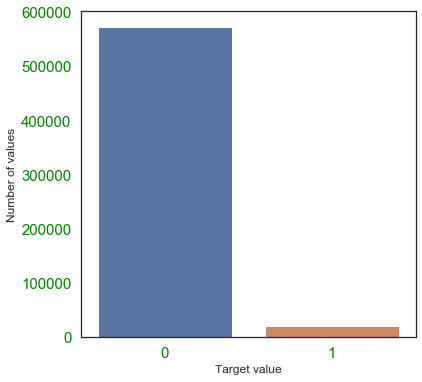

In [37]:
# Target variable 확인.
# 타이타닉에서도 했었음. 0과 1이 적절하게 섞여있는지, 균형이 안맞으면 조치가 필요하기 때문에. 
plt.figure()
fig, ax = plt.subplots(1, 1, figsize=(6,6))
x = trainset['target'].value_counts().index.values
y = trainset['target'].value_counts().values

# Bar plot
sns.barplot(ax=ax, x=x, y=y)
plt.ylabel('Number of values', fontsize=12)
plt.xlabel('Target value', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=15, labelcolor='green') # tick 에 관한 설정 가능.
plt.show()

.values : 딕셔너리 자료형 생성
Value만 얻고 싶다면 values 함수를 사용하면 된다. values 함수를 호출하면 dict_values 객체를 돌려줌.
Key-Value 관련 내용.
.keys() : key값 / items() : key, value 쌍 얻기

plt.tick_parmas()
< Parameters >
axis='x or y or both' , which axis to apply the parameters to. default both
reset=True/False , if True set all parameters to defaults. default False
which='major or minor or both' , apply arguments to which ticks. default major
length, width , tick length and width
color , tick color
labelsize , Tick label font size in points or as a string
labelcolor
pad , Distance in points between tick and label
labelrotaion , Tick label rotation (회전)

In [47]:
trainset.shape

(595212, 59)

In [55]:
trainset['target'].value_counts()[1]

21694

In [58]:
trainset['target']==1

0         False
1         False
2         False
3         False
4         False
          ...  
595207    False
595208    False
595209    False
595210    False
595211    False
Name: target, Length: 595212, dtype: bool

In [60]:
print('Target variable ratio', (trainset['target'].value_counts()[1] / len(trainset))*100, '%')
# 너무 코드가 지저분함. 깔금하게 정리. 정규표현식을 이용하면 좋을 것 같음.

Target variable ratio 3.6447517859182947 %
